In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import re
from convex_optimization_VSS_VPI import Network, Investors, Consumers, Example_Anaheim, Example, Example_6node, Example_3node
from Transportaion_test_systems import import_matrix, transportation_network_topo
import math

In [2]:
def getNumbers(str):
    array = re.findall(r'[0-9]+', str)
    return array

### Loading network parameters

In [3]:
congestion = False 
identical_scen = False 
Ntw = Example(identical_scen, congestion)
Ntw.C.b3

growth at scen  1 :  1.0268728488224803
growth at scen  2 :  1.1694867473874464
growth at scen  3 :  1.1527549237953227
growth at scen  4 :  1.0510138051478843
growth at scen  5 :  1.0990870174183882
growth at scen  6 :  1.0898982129577477
growth at scen  7 :  1.1303185945445526
growth at scen  8 :  1.1577446702271026
growth at scen  9 :  1.018771917354847
growth at scen  10 :  1.0056694953044012
growth at scen  11 :  1.167153020783974
growth at scen  12 :  1.0865534135810107
growth at scen  13 :  1.1524560164915885
growth at scen  14 :  1.0004212106702222
growth at scen  15 :  1.0890774388109603
growth at scen  16 :  1.1443080064681566
growth at scen  17 :  1.0457524442540904
growth at scen  18 :  1.1890541391107845
growth at scen  19 :  1.1802854915222967
growth at scen  20 :  1.0061179966067106


0.06

In [4]:
Ntw.C.b1

1

### Adding results paths

In [5]:
root = (os.getcwd())
results_path = root + '/Results'
directory_contents = sorted(os.listdir(results_path))
results_folders=[]
# for item in directory_contents:
#     if os.path.isdir(item):
# #         print(getNumbers(item))
#         results_folders.append(item)
        
final_results_path = os.path.join(results_path, directory_contents[-1])
# final_results_path = os.path.join(results_path, 'Results_20211121_1648')
determenistic_result_directory = os.path.dirname(os.getcwd()) + '/script_v8_deterministic_speed_up'

In [6]:
# directory_contents

### Figures setup

In [7]:
from collections import namedtuple, OrderedDict
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['lines.linewidth'] = 2
 
mpl.rc('font',family='Times New Roman', size=20)
fnt_size=30
fnt_size2=20
csfont = {'fontname':'Times New Roman',
                  'size': fnt_size,
                 'fontweight':'bold'}
csfont2 = {'fontname':'Times New Roman',
                  'size': fnt_size2}

Color = namedtuple('RGB','red, green, blue')
class RGB(Color):
    def hex_format(self):
        return '#{:02X}{:02X}{:02X}'.format(self.red,self.green,self.blue)

### Helper functions for reading results

In [8]:
def data_reader(file_name, result_type):
    
    
    scenarios = []
    nodes = []
    value = []
    value_dict={}
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            while("" in row):
                row.remove("")
#         row_numbers = getNumbers(row)
            scenarios.append(int(getNumbers(row[0])[0]))
            nodes.append(int(getNumbers(row[1])[0]))
            value.append(float(row[-1]))
            if result_type == 'Stochastic':
                value_dict[int(getNumbers(row[1])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
            elif result_type == 'Deterministic':
                value_dict[int(getNumbers(row[0])[0])] = float(row[-1])
    if result_type == 'Stochastic':        
        value_stochastic_dict= {'Nodes':nodes, 'Scenarios':scenarios, 'Values':value}
        value_stochastic_df = pd.DataFrame(value_stochastic_dict)
        
    elif result_type == 'Deterministic':        
        value_stochastic_dict= {'Nodes':nodes, 'Values':value}
        value_stochastic_df = pd.DataFrame(value_stochastic_dict)
            
    return value_stochastic_df, value_dict

def traffic_data_reader(file_name, traffic_type, results_type):
    
    if traffic_type == 'q':
        q={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if results_type == 'Stochastic':
                    if float(row[-1]) == 0:
                        q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1]) + 0.00001
                    else:
                        q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type == 'Deterministic':
                    if float(row[-1]) == 0:
                        q[int(getNumbers(row[0])[0]),int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0])] = float(row[-1]) + 0.00001
                    else:
                        q[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0])] = float(row[-1])
                
        return q
    
    elif traffic_type == 'x':
        x={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                    
                if results_type == 'Stochastic':
                    x[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[5])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type == 'Deterministic':
                    x[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0])] = float(row[-1])
                
        return x
    
    elif traffic_type == 'lamda':
        lamda={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if results_type =='Stochastic':
                    lamda[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type =='Deterministic':
                    lamda[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0])] = float(row[-1])
        return lamda
    
    elif traffic_type == 'mu':
        mu={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if results_type == 'Stochastic':
                    mu[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
                elif results_type == 'Deterministic':
                    mu[int(getNumbers(row[0])[0]), int(getNumbers(row[1])[0])] = float(row[-1]) 
        return mu
    
    else:
        print('Invalid traffic type; valid options are: q, x, lamda, mu')

# Prices

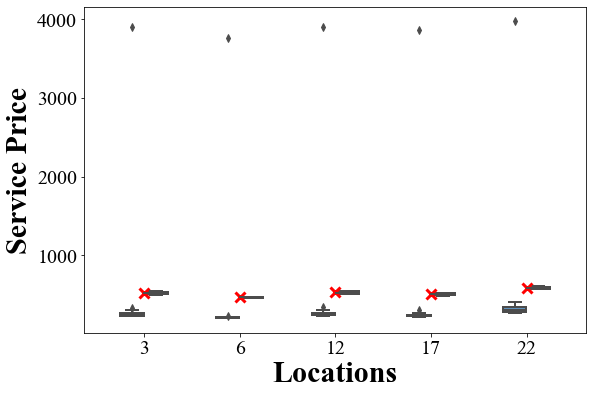

In [9]:
price_file_stochastic = os.path.join(final_results_path, 'Resulting_prices_Stochastic.csv')
price_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_prices_Wait_and_see.csv')
price_file_deterministic = os.path.join(final_results_path, 'Resulting_prices_Deterministic.csv')


prices_stochastic_df, rho_stochastic = data_reader(file_name=price_file_stochastic,result_type='Stochastic')

prices_stochastic_wo_anti_df, rho_stochastic_wo_anti = data_reader(file_name=price_file_stochastic_wo_anti,result_type='Stochastic')

combined_prices_df = pd.DataFrame()
combined_prices_df['Nodes'] = list(prices_stochastic_df.Nodes) + list(prices_stochastic_wo_anti_df.Nodes)
combined_prices_df['Scenarios'] = list(prices_stochastic_df.Scenarios) + list(prices_stochastic_wo_anti_df.Scenarios)
combined_prices_df['Values'] = list(prices_stochastic_df.Values) + list(prices_stochastic_wo_anti_df.Values)
combined_prices_df['Types'] = ['With anti']*len(prices_stochastic_df.Nodes) + ['WO anti']*len(prices_stochastic_wo_anti_df.Nodes)


prices_deterministic_df, rho_deterministic = data_reader(file_name=price_file_deterministic,result_type='Deterministic')

fig, ax = plt.subplots()
my_pal = {"With anti": RGB(79/255,148/255,205/255), "WO anti": RGB(255/255,128/255,0), 'VSS': 'red'}
ax = sns.boxplot(x='Nodes', y='Values', data=combined_prices_df, hue='Types', linewidth=2, width=0.5, palette = my_pal)
ax.scatter(range(len(prices_deterministic_df.Nodes)),prices_deterministic_df.Values, linewidth=3, marker='x', color='red', s=100)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Service Price",**csfont);
# legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
plt.savefig('./Figures/rho.png',dpi=500, format='png', bbox_inches='tight')

In [10]:
prices_deterministic_df

,Nodes,Values
0,519,519.264277
1,463,463.033659
2,526,526.263923
3,505,505.682305
4,586,586.810313


# Services (g)

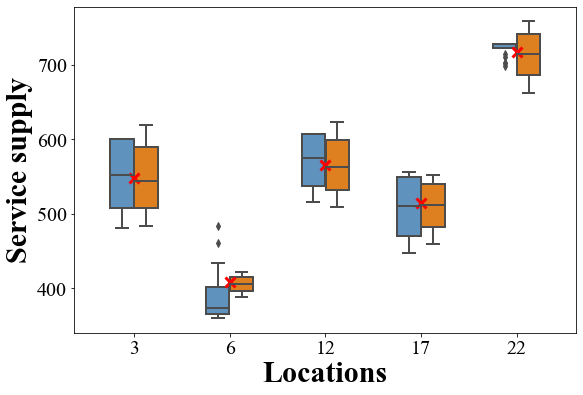

In [11]:
service_file_stochastic = os.path.join(final_results_path, 'Resulting_services_Stochastic.csv')
service_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_services_Wait_and_see.csv')
service_file_deterministic = os.path.join(final_results_path, 'Resulting_services_Deterministic.csv')


services_df_stochastic, g_stochastic = data_reader(file_name=service_file_stochastic,result_type='Stochastic')
services_df_stochastic_wo_anti, g_stochastic_wo_anti = data_reader(file_name=service_file_stochastic_wo_anti,result_type='Stochastic')
combined_services_df = pd.DataFrame()
combined_services_df['Nodes'] = list(services_df_stochastic.Nodes) + list(services_df_stochastic_wo_anti.Nodes)
combined_services_df['Scenarios'] = list(services_df_stochastic.Scenarios) + list(services_df_stochastic_wo_anti.Scenarios)
combined_services_df['Values'] = list(services_df_stochastic.Values) + list(services_df_stochastic_wo_anti.Values)
combined_services_df['Types'] = ['With anti']*len(services_df_stochastic.Nodes) + ['WO anti']*len(services_df_stochastic_wo_anti.Nodes)

services_df_deterministic, g_deterministic = data_reader(file_name=service_file_deterministic,result_type='Deterministic') 

fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_services_df, hue='Types', linewidth=2, width=0.5, palette = my_pal)
ax.scatter(range(len(services_df_deterministic.Nodes)), services_df_deterministic.Values, linewidth=3, color='red', marker ='x', s=100)
# ax.set_ylim(480,800)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Service supply",**csfont);
legend = plt.legend(loc='upper left',  title='Types',fontsize=20, frameon=False);
ax.get_legend().remove()
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
plt.savefig('./Figures/g.png',dpi=500, format='png', bbox_inches='tight')

# Capacity

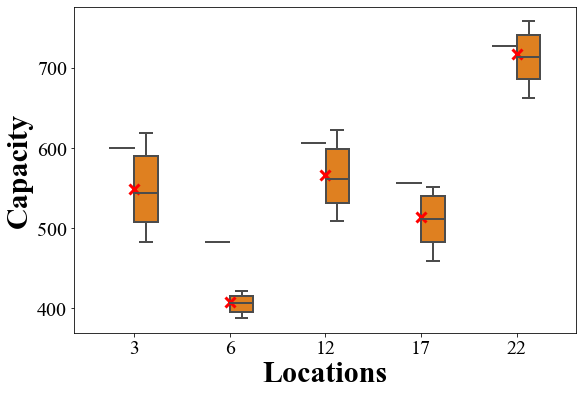

In [12]:
capacities_file_stochastic = os.path.join(final_results_path, 'Resulting_capacities_Stochastic.csv')
capacities_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_capacities_Wait_and_see.csv')
capacity_file_deterministic = os.path.join(final_results_path, 'Resulting_capacities_Deterministic.csv')

capacity_df_stochastic, c_stochastic = data_reader(file_name=capacities_file_stochastic,result_type='Stochastic')
capacity_df_stochastic_wo_anti, c_stochastic_wo_anti = data_reader(file_name=capacities_file_stochastic_wo_anti,result_type='Stochastic')
combined_capacity_df = pd.DataFrame()
combined_capacity_df['Nodes'] = list(capacity_df_stochastic.Nodes) + list(capacity_df_stochastic_wo_anti.Nodes)
combined_capacity_df['Scenarios'] = list(capacity_df_stochastic.Scenarios) + list(capacity_df_stochastic_wo_anti.Scenarios)
combined_capacity_df['Values'] = list(capacity_df_stochastic.Values) + list(capacity_df_stochastic_wo_anti.Values)
combined_capacity_df['Types'] = ['With anti']*len(capacity_df_stochastic.Nodes) + ['WO anti']*len(capacity_df_stochastic_wo_anti.Nodes)


capacity_df_deterministic, c_deterministic = data_reader(file_name=capacity_file_deterministic,result_type='Deterministic')


fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_capacity_df, hue= 'Types', linewidth=2, width=0.5, palette = my_pal)
ax.scatter(range(len(capacity_df_deterministic.Nodes)), capacity_df_deterministic.Values, linewidth=3, color='red', marker ='x', s=100)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Capacity",**csfont);
legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
plt.savefig('./Figures/c.png',dpi=500, format='png', bbox_inches='tight')

# Traffic

In [13]:
Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_traffic_Stochastic.csv')
Traffic_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_traffic_Wait_and_see.csv')
Traffic_file_Deterministic = os.path.join(final_results_path, 'Resulting_traffic_Deterministic.csv')
# Traffic_file_deterministic = os.path.join(determenistic_result_directory, 'Results_traffic.csv')

q_stochastic = traffic_data_reader(Traffic_file_stochastic,'q','Stochastic')
q_stochastic_wo_anti = traffic_data_reader(Traffic_file_stochastic_wo_anti,'q','Stochastic')
q_deterministic = traffic_data_reader(Traffic_file_Deterministic,'q','Deterministic')

Link_Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_link_traffic_Stochastic.csv')
Link_Traffic_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_link_traffic_Wait_and_see.csv')
Link_Traffic_file_Deterministic = os.path.join(final_results_path, 'Resulting_link_traffic_Deterministic.csv')

x_stochastic = traffic_data_reader(Link_Traffic_file_stochastic, 'x', 'Stochastic')
x_stochastic_wo_anti = traffic_data_reader(Link_Traffic_file_stochastic_wo_anti, 'x', 'Stochastic')
x_deterministic = traffic_data_reader(Link_Traffic_file_Deterministic, 'x', 'Deterministic')


lamda1_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda1_Stochastic.csv')
lamda1_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_lamda1_Wait_and_see.csv')
lamda1_file_Deterministic = os.path.join(final_results_path, 'Resulting_lamda1_Deterministic.csv')

lamda1_stochastic = traffic_data_reader(lamda1_file_stochastic, 'lamda', 'Stochastic')
lamda1_stochastic_wo_anti = traffic_data_reader(lamda1_file_stochastic, 'lamda', 'Stochastic')
lamda1_deterministic = traffic_data_reader(lamda1_file_Deterministic, 'lamda', 'Deterministic')

lamda2_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda2_Stochastic.csv')
lamda2_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_lamda2_Wait_and_see.csv')
lamda2_file_Deterministic = os.path.join(final_results_path, 'Resulting_lamda2_Deterministic.csv')

lamda2_stochastic = traffic_data_reader(lamda2_file_stochastic, 'lamda', 'Stochastic')
lamda2_stochastic_wo_anti = traffic_data_reader(lamda2_file_stochastic, 'lamda', 'Stochastic')
lamda2_deterministic = traffic_data_reader(lamda2_file_Deterministic, 'lamda', 'Deterministic')

mu_file_stochastic = os.path.join(final_results_path, 'Resulting_mu_Stochastic.csv')
mu_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_mu_Wait_and_see.csv')
mu_file_Deterministic = os.path.join(final_results_path, 'Resulting_mu_Deterministic.csv')

mu_stochastic = traffic_data_reader(mu_file_stochastic, 'mu', 'Stochastic')
mu_stochastic_wo_anti = traffic_data_reader(mu_file_stochastic_wo_anti, 'mu', 'Stochastic')
mu_deterministic = traffic_data_reader(mu_file_Deterministic, 'mu', 'Deterministic')

# Surpluss analysis

### Investors cost calculation

In [14]:
Investors_total_cost = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) +
    (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

Investors_total_cost_wo_anti = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) +
    (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
print('Investors costs       With non-anti      WO non-anti')
print('                     ', round(Investors_total_cost,4), '     ', round(Investors_total_cost_wo_anti,4))

Investors costs       With non-anti      WO non-anti
                      1200865.3238       1140071.4525


### Investors objective calculation

In [15]:
Investors_objective = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic[k,u]*g_stochastic[k,u] -
        (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) - 
        (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

Investors_objective_wo_anti = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic_wo_anti[k,u]*g_stochastic_wo_anti[k,u] -
        (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) - 
        (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
print('Investors Obj       With non-anti      WO non-anti')
print('                   ', round(Investors_objective,5), '     ', round(Investors_objective_wo_anti,4))

Investors Obj       With non-anti      WO non-anti
                    337674.60937       314280.5943


In [16]:
Investors_objective - Investors_objective_wo_anti


23394.015058019257

### Calculating utility and ravel time based on x

In [17]:
def travel_time(Ntw,lamda1,lamda2,mu):
    t={}
    A={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    A[r,s,k,u] = lamda1[r,s,k,r,u] - lamda1[r,s,k,k,u]  + lamda2[r,s,k,k,u] - lamda2[r,s,k,s,u]
                    t[r,s,k,u] = (Ntw.C.b3/(Ntw.C.b1*Ntw.Scn.pr[u])) * A[r,s,k,u]
#                     t[r,s,k,u] = (Ntw.C.b3/Ntw.Scn.pr[u]) * (A[r,s,k,u]- mu[r,s,u])
#                     t[r,s,k,u] = sum(Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((x[i,j,r,s,k,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
                    
    return t

def travel_time_deterministic(Ntw,lamda1,lamda2,mu):
    t={}
    A={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                A[r,s,k] = lamda1[r,s,k,r] - lamda1[r,s,k,k]  + lamda2[r,s,k,k] - lamda2[r,s,k,s]
                t[r,s,k] = (Ntw.C.b3/(Ntw.C.b1)) * A[r,s,k]
#                     t[r,s,k,u] = (Ntw.C.b3/Ntw.Scn.pr[u]) * (A[r,s,k,u]- mu[r,s,u])
#                     t[r,s,k,u] = sum(Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((x[i,j,r,s,k,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
                    
    return t

def Utility_func(Ntw,lamda1,lamda2,mu,q,rho):
    t_time = travel_time(Ntw,lamda1,lamda2,mu)
    U={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    U[r,s,k,u] = Ntw.C.b0[k] - Ntw.C.b1 * t_time[r,s,k,u]- Ntw.C.b3*rho[k,u] * Ntw.C.e[r,s]
                    
                    
    return U

def Utility_func_deterministic(Ntw,lamda1,lamda2,mu,q,rho):
    t_time = travel_time_deterministic(Ntw,lamda1,lamda2,mu)
    U={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                U[r,s,k] = Ntw.C.b0[k] - Ntw.C.b1 * t_time[r,s,k]- Ntw.C.b3*rho[k] * Ntw.C.e[r,s]
                    
                    
    return U

In [18]:
# travel_time(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic)

In [19]:
Utility_stochastic = Utility_func(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic,q_stochastic,rho_stochastic)
Utility_stochastic_wo_anti = Utility_func(Ntw,lamda1_stochastic_wo_anti,lamda2_stochastic_wo_anti,mu_stochastic_wo_anti,q_stochastic_wo_anti,rho_stochastic_wo_anti)
Utility_deterministic = Utility_func_deterministic(Ntw,lamda1_deterministic,lamda2_deterministic,mu_deterministic,q_deterministic,rho_deterministic)

total_utility = sum (Ntw.Scn.pr[u]*(Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)
total_utility_wo_anti = sum (Ntw.Scn.pr[u]* (Utility_stochastic_wo_anti[r,s,k,u] * q_stochastic_wo_anti[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)
total_utility_deterministic = sum ( (Utility_deterministic[r,s,k] * q_deterministic[r,s,k]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K)

### Surplus calculation

In [20]:
Surpluss_stochastic = Investors_objective + sum (Ntw.Scn.pr[u]*(Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

Surpluss_stochastic_wo_anti = Investors_objective_wo_anti + sum (Ntw.Scn.pr[u]* (Utility_stochastic_wo_anti[r,s,k,u] * q_stochastic_wo_anti[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

print('Surplus       With non-anti      WO non-anti')
print('              ', round(Surpluss_stochastic,4), '     ', round(Surpluss_stochastic_wo_anti,4))

Surplus       With non-anti      WO non-anti
               -3342577.5264       -3281745.9378


# EVPI analysis

## Investors

In [21]:
EVPI_investors = Investors_objective - Investors_objective_wo_anti
EVPI_investors

23394.015058019257

## Consumers 

In [22]:
def consumer_obj_func(Ntw,q,x,rho,c):
    v = {}
    for (r,s) in Ntw.C.A:
        for u in Ntw.Scn.U:
            v[r,s,u] = sum (x[r,s,i,j,k,u] for i in Ntw.C.R for j in Ntw.C.S for k in Ntw.C.K)
    
    exp0 = {}
    exp1 = {}
    
    
    for u in Ntw.Scn.U:
        
        exp0[u] = sum(Ntw.C.tff[r,s]*(v[r,s,u]+(Ntw.C.b[r,s]/(Ntw.C.alpha[r,s]+1.0))*(v[r,s,u]**(Ntw.C.alpha[r,s]+1))/(Ntw.C.cap[r,s]**(Ntw.C.alpha[r,s]))) for (r,s) in Ntw.C.A)
        exp1[u] = 1.0/Ntw.C.b1*( sum( q[r,s,k,u]*( math.log(q[r,s,k,u]) - 1.0 + Ntw.C.b3 * rho[k,u] * Ntw.C.e[r,s] - Ntw.C.b0[k]) for k in Ntw.C.K for s in Ntw.C.S for r in Ntw.C.R))
        
    consumer_obj = sum(exp0[u] + exp1[u] for u in Ntw.Scn.U) 
    
    return consumer_obj


In [23]:
# for r in Ntw.C.R:
#     for s in Ntw.C.S:
#         for k in Ntw.C.K:
#             for u in Ntw.Scn.U:
#                 print('(', r,s,k,u,')   ', q_stochastic[r,s,k,u])

In [24]:
Consumers_objective = consumer_obj_func(Ntw,q_stochastic,x_stochastic,rho_stochastic,c_stochastic)
Consumers_objective_wo_anti = consumer_obj_func(Ntw,q_stochastic_wo_anti,
                                                x_stochastic_wo_anti,
                                                rho_stochastic_wo_anti,
                                                c_stochastic_wo_anti)

EVPI_consumers = Consumers_objective_wo_anti - Consumers_objective
EVPI_consumers

232930.80548412353

# Total travel time comparison

In [25]:
def total_travel_time(Ntw, x):
    v = {}
    for (i,j) in Ntw.C.A:
        for u in Ntw.Scn.U:
            v[i,j,u] = sum (x[i,j,r,s,k,u] for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K)
            
    tt_time = sum(v[i,j,u] * Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((v[i,j,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
    
    return tt_time

In [26]:
tt_time = total_travel_time(Ntw, x_stochastic)
tt_time_wo_anti = total_travel_time(Ntw, x_stochastic_wo_anti)

print('Total travel time       With non-anti      WO non-anti')
print('                       ', round(tt_time,4), '       ', round(tt_time_wo_anti,4))

Total travel time       With non-anti      WO non-anti
                        74459.3356         74593.7973


# VSS

In [27]:
file_name = os.path.join(final_results_path, 'Resulting_objective_VSS_investors.csv')
with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            Investors_objective_VSS = float(row[0])
            
Surplus_VSS = Investors_objective_VSS + sum ((Utility_deterministic[r,s,k] * q_deterministic[r,s,k]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K)

In [28]:
Results_data={'criteria':['Providers','Providers','Providers','Users','Users','Users','Surplus','Surplus','Surplus'],
             'value':[Investors_objective_VSS, Investors_objective,Investors_objective_wo_anti, total_utility_deterministic, total_utility, total_utility_wo_anti, Surplus_VSS, Surpluss_stochastic, Surpluss_stochastic_wo_anti],
             'Type': ['VSS','With anti','WO anti','VSS','With anti','WO anti','VSS','With anti','WO anti']}
Results_df = pd.DataFrame(Results_data)

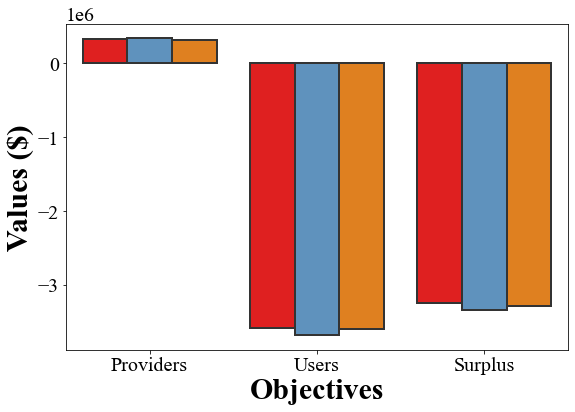

In [29]:
fig, ax = plt.subplots()
ax = sns.barplot(x='criteria', y='value', data=Results_df, hue= 'Type', linewidth=2, edgecolor=".2", palette = my_pal)
ax.set_xlabel("Objectives",**csfont)
ax.set_ylabel("Values (\$)",**csfont);
legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
plt.savefig('./Figures/EVPI.png',dpi=500, format='png', bbox_inches='tight')